[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aderdouri/PINNs/blob/master/Tutorials/Elliptic1D.ipynb)

# Tensorflow Implementation

To highlight different implementation aspects, consider a simple linear elliptic PDE in one dimension:

$$
u_{xx}(x) = f(x), \ \ x\in[-1.0,1.0],\\
u(-1)=u(1) = 0,
$$
with a forcing term given by
$$
f(x):= -\pi^2 \sin(\pi x)
$$

All elements defining our neural network implementation can be summarized in the following Tensorflow class.

In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [43]:
# Define the forcing term and exact solution
def f_tf(x):
    return -np.pi**2 * tf.sin(np.pi * x)

def u_exact(x):
    return tf.sin(np.pi * x)

In [44]:
# Define the PINN model
class PINNsModel(tf.keras.Model):
    def __init__(self, layers):
        super(PINNsModel, self).__init__()
        self.hidden_layers = []
        for units in layers[:-1]:
            self.hidden_layers.append(tf.keras.layers.Dense(units, activation='tanh',
                                                            kernel_initializer='glorot_normal'))
        self.output_layer = tf.keras.layers.Dense(layers[-1], activation=None,
                                                  kernel_initializer='glorot_normal')

    def call(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Define the loss function
def loss_function(model, x_u, u_b, x_r):
    # Boundary loss
    u_pred_b = model(x_u)
    loss_b = tf.reduce_mean(tf.square(u_b - u_pred_b))

    # Residual loss
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_r)
        u_pred = model(x_r)
        u_x = tape.gradient(u_pred, x_r)
    u_xx = tape.gradient(u_x, x_r)
    del tape
    f_pred = f_tf(x_r)
    loss_r = tf.reduce_mean(tf.square(u_xx - f_pred))

    return loss_b, loss_r

# Training function
def train(model, optimizer, x_u, u_b, x_r, epochs):
    loss_b_log = []
    loss_r_log = []

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss_b, loss_r = loss_function(model, x_u, u_b, x_r)
            total_loss = loss_b + loss_r
        gradients = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        loss_b_log.append(loss_b.numpy())
        loss_r_log.append(loss_r.numpy())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Total Loss: {total_loss.numpy()}, Boundary Loss: {loss_b.numpy()}, Residual Loss: {loss_r.numpy()}")

    return loss_b_log, loss_r_log

In [46]:
# Define the domain and training data
N_b = 2   # Number of boundary points
N_r = 100 # Number of collocation points

# Boundary points
x_u = tf.convert_to_tensor([[-1.0], [1.0]], dtype=tf.float32)
u_b = tf.convert_to_tensor([[0.0], [0.0]], dtype=tf.float32)

# Collocation points
x_r = tf.convert_to_tensor(np.random.uniform(-1, 1, size=(N_r, 1)), dtype=tf.float32)

# Define the PINNs model
layers = [1, 20, 20, 20, 1]  # Input, 3 hidden layers, output
pinns = PINNsModel(layers)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Train the model
loss_u_log, loss_r_log = train(pinns, optimizer, x_u, u_b, x_r, epochs=10_000)

Epoch 0, Total Loss: 50.9399528503418, Boundary Loss: 4.3811446914787666e-08, Residual Loss: 50.9399528503418
Epoch 100, Total Loss: 21.232162475585938, Boundary Loss: 0.5873107314109802, Residual Loss: 20.644851684570312
Epoch 200, Total Loss: 1.0145113468170166, Boundary Loss: 0.029978515580296516, Residual Loss: 0.9845328330993652
Epoch 300, Total Loss: 0.48193198442459106, Boundary Loss: 0.001456948695704341, Residual Loss: 0.4804750382900238
Epoch 400, Total Loss: 0.1721021682024002, Boundary Loss: 0.00015865397290326655, Residual Loss: 0.1719435155391693
Epoch 500, Total Loss: 0.06459901481866837, Boundary Loss: 0.00021542178001254797, Residual Loss: 0.0643835961818695
Epoch 600, Total Loss: 0.017355671152472496, Boundary Loss: 5.65598311368376e-05, Residual Loss: 0.017299111932516098
Epoch 700, Total Loss: 0.009164734743535519, Boundary Loss: 1.8223227016278543e-05, Residual Loss: 0.009146511554718018
Epoch 800, Total Loss: 0.007311781868338585, Boundary Loss: 2.9811661079293117

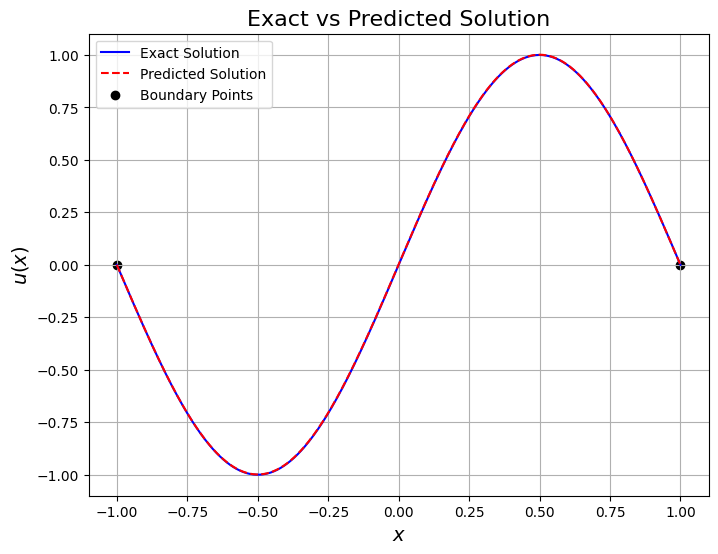

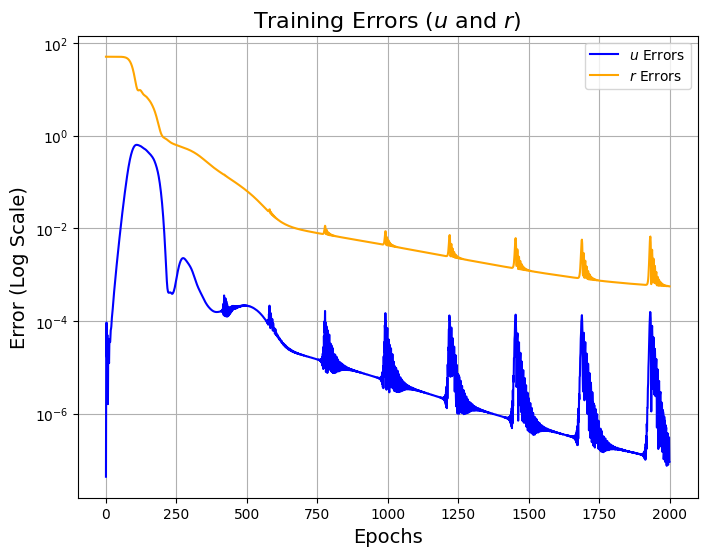

In [47]:
# Validation
x_star = tf.convert_to_tensor(np.linspace(-1, 1, 500)[:, None], dtype=tf.float32)
u_star = u_exact(x_star)
u_pred = pinns(x_star)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(x_star, u_star, 'b-', label='Exact Solution')
plt.plot(x_star, u_pred, 'r--', label='Predicted Solution')
plt.scatter(x_u, u_b, color='black', label='Boundary Points')
plt.legend()
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$u(x)$', fontsize=14)
plt.title('Exact vs Predicted Solution', fontsize=16)
plt.grid(True)
plt.show()


# Plot error logs
plt.figure(2, figsize=(8, 6))
plt.plot(loss_u_log, label='$u$ Errors', color='blue')
plt.plot(loss_r_log, label='$r$ Errors', color='orange')
plt.yscale('log')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Error (Log Scale)', fontsize=14)
plt.title('Training Errors ($u$ and $r$)', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()